In [1]:
import pandas as pd
import numpy as np
import sys

## Import Data - (Rossmann)

In [2]:
samp = pd.read_csv('../../rossmann-store-sales/sample_submission.csv')

train = pd.read_csv('../../rossmann-store-sales/train.csv')
train['Date'] = pd.to_datetime(train['Date'])

test = pd.read_csv('../../rossmann-store-sales/test.csv')
test['Date'] = pd.to_datetime(test['Date'])

store = pd.read_csv('../../rossmann-store-sales/store.csv')


C:\Users\brock\AppData\Local\Temp\ipykernel_64660\2153528293.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../rossmann-store-sales/train.csv')


In [3]:
print("------------------------------------------------------------/n")
print('Train:\n', train.head(), train.shape)
print("------------------------------------------------------------/n")
print('Test:\n', test.head(), test.shape)
print("------------------------------------------------------------/n")
print('Store:\n', store.head())

------------------------------------------------------------/n
Train:
    Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1   (1017209, 9)
------------------------------------------------------------/n
Test:
    Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17 

Let's go ahead and convert alphabetical 'StoreType and 'Assortment' to numerical. 

In [4]:
print(store.StoreType.describe())
print(store.Assortment.describe())
print(train.StateHoliday.describe())
print(train.StateHoliday.unique())

count     1115
unique       4
top          a
freq       602
Name: StoreType, dtype: object
count     1115
unique       3
top          a
freq       593
Name: Assortment, dtype: object
count     1017209
unique          5
top             0
freq       855087
Name: StateHoliday, dtype: object
['0' 'a' 'b' 'c' 0]


In [5]:
type_map = {'a':'1', 'b':'2', 'c':'3', 'd':'4'}
assort_map = {'a':'1', 'b':'2', 'c':'3'}
store['StoreType'] = store['StoreType'].replace(type_map)
store['Assortment'] = store['Assortment'].replace(assort_map)
train['StateHoliday'] = train['StateHoliday'].replace(assort_map)
store['StoreType'] = pd.to_numeric(store['StoreType'])
store['Assortment'] = pd.to_numeric(store['Assortment'])
train['StateHoliday'] = pd.to_numeric(train['StateHoliday'])
store=store.drop('PromoInterval', axis=1)

In [6]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 9))

## Data Preprocessing

In [7]:
train_store = train.merge(store, how='inner', on="Store")
test_store = test.merge(store, how='inner', on="Store")

train_store['Date'] = pd.to_datetime(train_store['Date'])
test_store['Date'] = pd.to_datetime(test_store['Date'])


train_store['Year'] = train_store['Date'].dt.year
train_store['Month'] = train_store['Date'].dt.month
train_store['Day'] = train_store['Date'].dt.day
train_store['WeekOfYear'] = (train_store.Date.dt.isocalendar().week)*1.0
test_store['Year'] = test_store['Date'].dt.year
test_store['Month'] = test_store['Date'].dt.month
test_store['Day'] = test_store['Date'].dt.day
test_store['WeekOfYear'] = (test_store.Date.dt.isocalendar().week)*1.0

train_df = train_store
test_df = test_store

test_df=test_df.drop('Id', axis=1)


print(train_df.head())
print(train_df.columns)
print('Shape: ', train_df.shape)
print("------------------------------------------------------------/n")
print(test_df.head())
print(test_df.columns)
print('Shape: ', test.shape)

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      1          4 2015-07-30   5020        546     1      1             0   
2      1          3 2015-07-29   4782        523     1      1             0   
3      1          2 2015-07-28   5011        560     1      1             0   
4      1          1 2015-07-27   6102        612     1      1             0   

   SchoolHoliday  StoreType  ...  CompetitionDistance  \
0              1          3  ...               1270.0   
1              1          3  ...               1270.0   
2              1          3  ...               1270.0   
3              1          3  ...               1270.0   
4              1          3  ...               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    20

Now we have our training and testing sets

Let's look at the training data first. Are there any features we can alter or drop?

In [8]:
## Closed stores and 0-Sale stores
train_df[(train_df.Open==0) & (train_df.Sales==0)].shape

(172817, 21)

172k closed stores or stores with zero-sales. We can drop them. 

In [9]:
train_df = train_df[(train_df.Open!=0) & (train_df.Sales!=0)]
train_df.shape

(844338, 21)

In [10]:
# NaNs
train_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

In [11]:
# Fill NaN
train_df = train_df.fillna(0)

Let's generate another correlation matrix now that we have merged and adjusted the features.

C:\Users\brock\AppData\Local\Temp\ipykernel_64660\1765373117.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.drop('Open', axis=1).corr()


<AxesSubplot: title={'center': 'Correlation Matrix'}>

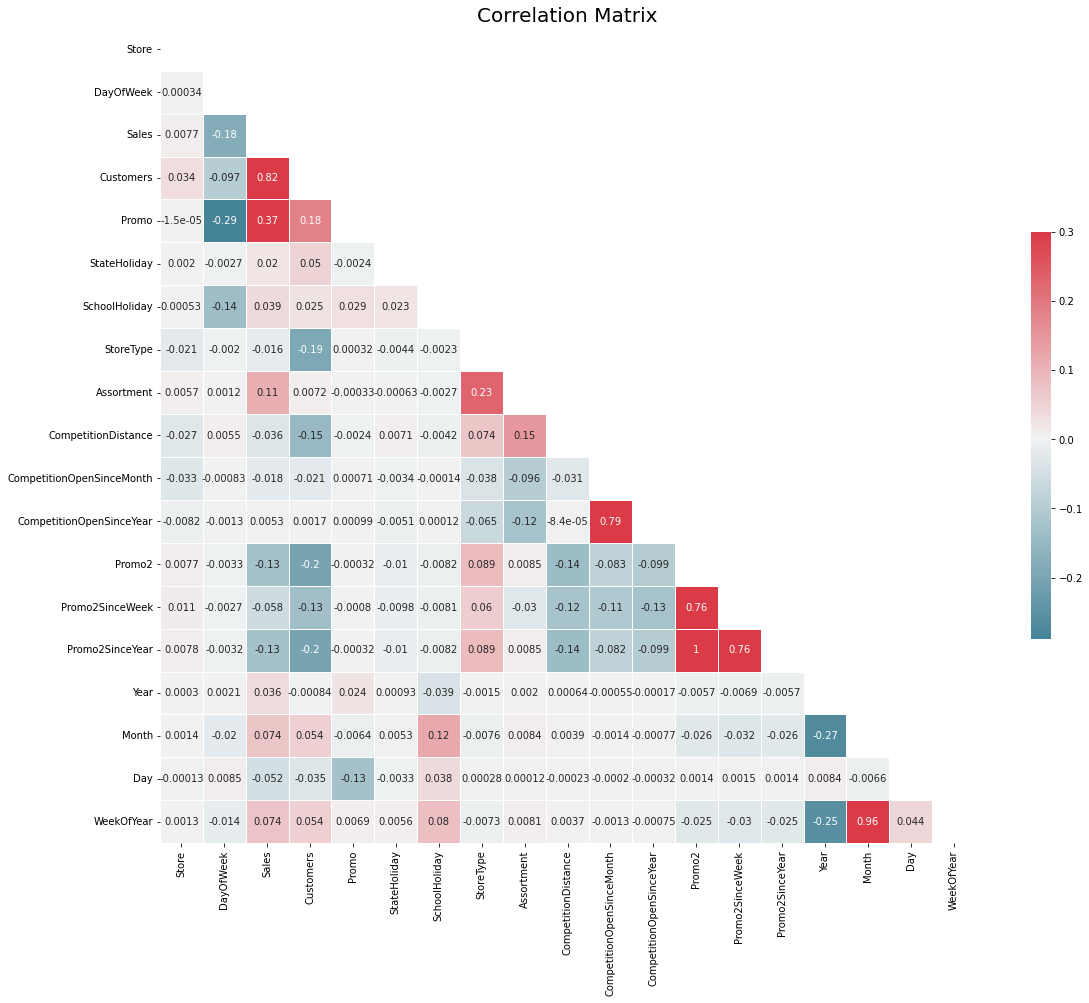

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = train_df.drop('Open', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=20)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [13]:
# Build input and target
train_cols = train_df.columns.to_list()
print(train_cols)
train_cols.remove('Sales')

train = train_df[train_cols].copy()
target = train_df['Sales'].copy()

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear']


In [14]:
print(train.info())
print('-----------------------------------------------------\n')
print(target.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Customers                  844338 non-null  int64         
 4   Open                       844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  int64         
 7   SchoolHoliday              844338 non-null  int64         
 8   StoreType                  844338 non-null  int64         
 9   Assortment                 844338 non-null  int64         
 10  CompetitionDistance        844338 non-null  float64       
 11  CompetitionOpenSinceMonth  844338 non-null  float64

#### Train Test Split

Now that we have finished our preprocessing, we can get our testing and training sets. 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train, target, test_size=0.3, random_state=1
)
print('X_train:',X_train.info(), X_train.head(5), X_train.shape)
print('y_train:',y_train.info(), y_train.head(5),y_train.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591036 entries, 107154 to 154790
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      591036 non-null  int64         
 1   DayOfWeek                  591036 non-null  int64         
 2   Date                       591036 non-null  datetime64[ns]
 3   Customers                  591036 non-null  int64         
 4   Open                       591036 non-null  int64         
 5   Promo                      591036 non-null  int64         
 6   StateHoliday               591036 non-null  int64         
 7   SchoolHoliday              591036 non-null  int64         
 8   StoreType                  591036 non-null  int64         
 9   Assortment                 591036 non-null  int64         
 10  CompetitionDistance        591036 non-null  float64       
 11  CompetitionOpenSinceMonth  591036 non-null  flo

In [16]:
# Standardize
from sklearn.preprocessing import StandardScaler

X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)

scaler = StandardScaler().fit((X_train))

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [17]:
# Define function to evaluate models 
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

## Linear Regression
We are now ready to train our (SKLearn's) Linear Regression model.

In [18]:
# Drop features that interfere wit LR

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import time 

lr = LinearRegression()
st = time.time()
lr.fit(X_train, y_train)
en = time.time()
fit_time = (en-st)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

lr = LinearRegression()
st = time.time()
lr.fit(X_train_std, y_train)
en = time.time()
fit_time_std = (en-st)

pred_train_std = lr.predict(X_train_std)
pred_test_std = lr.predict(X_test_std)

## R2
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

r2_train_std = r2_score(y_train, pred_train_std)
r2_test_std = r2_score(y_test, pred_test_std)

## TIME
print('Fit Time: ', fit_time)
print('Fit Time (STD):', fit_time_std)

print("R2 Scores\n---------------------\n")
print("R2 (train) for %s: %0.5f%% " % ('LR', r2_train))
print("R2 (test) for %s: %0.5f%% " % ('LR', r2_test))
print("R2 (train - STD) for %s: %0.5f%% " % ('LR', r2_train_std))
print("R2 (test - STD) for %s: %0.5f%% \n\n" % ('LR', r2_test_std))

## MSE
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)
mse_train_std = mean_squared_error(y_train, pred_train_std)
mse_test_std = mean_squared_error(y_test, pred_test_std)

print("MSE Scores\n---------------------\n")
print("MSE (train) for %s: %0.5f%% " % ('LR', mse_train))
print("MSE (test) for %s: %0.5f%% " % ('LR', mse_test))
print("MSE (train - STD) for %s: %0.5f%% " % ('LR', mse_train_std))
print("MSE (test - STD) for %s: %0.5f%% " % ('LR', mse_test_std))


Fit Time:  0.48522138595581055
Fit Time (STD): 0.6384420394897461
R2 Scores
---------------------

R2 (train) for LR: 0.76455% 
R2 (test) for LR: 0.76606% 
R2 (train - STD) for LR: 0.76455% 
R2 (test - STD) for LR: 0.76606% 


MSE Scores
---------------------

MSE (train) for LR: 2264671.15577% 
MSE (test) for LR: 2262029.39094% 
MSE (train - STD) for LR: 2264671.15577% 
MSE (test - STD) for LR: 2262029.39094% 


## Ridge Regression

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import time 

lr = Ridge(alpha=0.1)
st = time.time()
lr.fit(X_train, y_train)
en = time.time()
fit_time = (en-st)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

lr = Ridge(alpha=0.1)
st = time.time()
lr.fit(X_train_std, y_train)
en = time.time()
fit_time_std = (en-st)

pred_train_std = lr.predict(X_train_std)
pred_test_std = lr.predict(X_test_std)

## R2
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

r2_train_std = r2_score(y_train, pred_train_std)
r2_test_std = r2_score(y_test, pred_test_std)

## TIME
print('Fit Time: ', fit_time)
print('Fit Time (STD):', fit_time_std)

print("R2 Scores\n---------------------\n")
print("R2 (train) for %s: %0.5f%% " % ('LR', r2_train))
print("R2 (test) for %s: %0.5f%% " % ('LR', r2_test))
print("R2 (train - STD) for %s: %0.5f%% " % ('LR', r2_train_std))
print("R2 (test - STD) for %s: %0.5f%% \n\n" % ('LR', r2_test_std))

## MSE
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)
mse_train_std = mean_squared_error(y_train, pred_train_std)
mse_test_std = mean_squared_error(y_test, pred_test_std)

print("MSE Scores\n---------------------\n")
print("MSE (train) for %s: %0.5f%% " % ('LR', mse_train))
print("MSE (test) for %s: %0.5f%% " % ('LR', mse_test))
print("MSE (train - STD) for %s: %0.5f%% " % ('LR', mse_train_std))
print("MSE (test - STD) for %s: %0.5f%% " % ('LR', mse_test_std))

Fit Time:  0.23078274726867676
Fit Time (STD): 0.08049297332763672
R2 Scores
---------------------

R2 (train) for LR: 0.76448% 
R2 (test) for LR: 0.76597% 
R2 (train - STD) for LR: 0.76452% 
R2 (test - STD) for LR: 0.76602% 


MSE Scores
---------------------

MSE (train) for LR: 2265374.53164% 
MSE (test) for LR: 2262850.87849% 
MSE (train - STD) for LR: 2264929.34258% 
MSE (test - STD) for LR: 2262357.71380% 
